# Misleading Trump Ad

In early March of 2020, President Trump bought targetted advertisements on Facebook asking people to fill out a census form. Facebook removed these ads stating

"There are policies in place to prevent confusion around the official U.S. Census and this is an example of those being enforced."

I'm curious if there is any pattern to how this advertisement was targetted. This is an initial analysis.

Link to Vox article is [here.](https://www.vox.com/recode/2020/3/5/21166135/facebook-trump-ads-census-deceptive-census-2020?fbclid=IwAR2-Ix8xIgGBfdaIbrZ6vexNoq7MsY0rCL-h23VknLvOeP7D5swuvp6oxyA)

## Setup

In [174]:
%matplotlib inline

In [1]:
import yaml
import requests
#import csv
#import re
#from tqdm import tqdm
#from itertools import product
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
sns.set_style("white")
import numpy as np

with open('../queries/trump_census_ad.yaml', 'r') as f:
    query = yaml.safe_load(f)
    
with open('../token.yaml', 'r') as f:
    token = yaml.safe_load(f)

## Load Supplemental Data

In [11]:
state_populations = pd.read_csv('../data/State Populations.csv')
state_political_affiliation = pd.read_csv('../data/states_by_politcal_affiliation_2017_gallup.csv', index_col=0)

## Query Facebook Ad Library

In [12]:
query_params = {'access_token': token['access_token'],
                'ad_type': 'POLITICAL_AND_ISSUE_ADS',
                'ad_reached_countries': "['US']",
                'ad_active_status': query['ad_active_status'],
                'search_terms': query.get('search_terms'),
                'search_page_ids': ",".join(query.get('search_page_ids', [])),
                'fields': ",".join(query['query_fields']),
                'limit': query['page_total']}

In [13]:
r = requests.get('https://graph.facebook.com/v5.0/ads_archive',params=query_params)
data = r.json()

## Put Results into a DataFrame

In [21]:
def create_df_results(query_result, search_terms_list = ['fake news', 'democrat']):
    df = pd.DataFrame()
    for curr_ad in query_result['data']:
        ts = curr_ad['ad_creation_time']
        ts = ts.split('+')[0]
        ts = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S")
        
        percentages = [region_dict['percentage'] for region_dict in curr_ad['region_distribution']]
        region = [region_dict['region'] for region_dict in curr_ad['region_distribution']]

        temp_df = pd.DataFrame()
        temp_df['region'] = region
        temp_df['percentage'] = percentages
        temp_df['id'] = curr_ad['id']
        temp_df['ts'] = ts
                
        sentence = curr_ad['ad_creative_body']
        sentence = sentence.lower()
        
        for search_term in search_terms_list:
            search_term = search_term.lower()
            temp_df['contains_{}'.format(search_term)] = search_term in sentence

        df =  pd.concat((df, temp_df))

    df.percentage = pd.to_numeric(df.percentage)
    
    df = pd.merge(df, state_populations, how='left', left_on='region', right_on = 'State')
    df = pd.merge(df, political_affiliation, how='left', left_on='State', right_on = 'State')
    df['people'] = df['percentage']*df['2018 Population']
    df = df.sort_values('State')
    df = df.dropna()
    
    return df

In [36]:
search_terms = ['fake news', 'patriot', 'democrat', 'republican']

In [37]:
df = create_df_results(data,search_terms)

## Plot Results

In [23]:
colors_lookup = {'Solid Rep':'crimson',
         'Lean Rep':'red',
         'Competitive': 'purple',
          'Lean Dem':'blue',
          'Solid Dem':'darkblue'}

In [64]:
def make_plot(df, x='people', y='State', title=''):
    if len(df)>0:
        fig = plt.figure(figsize = (10,30))

        ax = sns.stripplot(x=x,
                           y=y, 
                           data=df, 
                           size=8,
                           hue='Classification', 
                           palette = colors_lookup, 
                           hue_order =list(colors_lookup.keys()))
        
        ax.tick_params(labelsize=18)


        percents = np.array([0,.25,.5,.75,1])
        tick_vals = np.max(df['people'])*percents
        plt.xticks(tick_vals, percents);
        
        ax.legend_.remove()
        #plt.legend(loc='lower right',fontsize=20);
        plt.ylabel(' ')
        plt.xlabel('Normalized Targeted Percentage', fontsize=20)
        plt.title(title, fontsize=24)

        sns.despine(fig)
        plt.savefig('{}.png'.format(title.replace('"', '')),bbox_inches='tight')

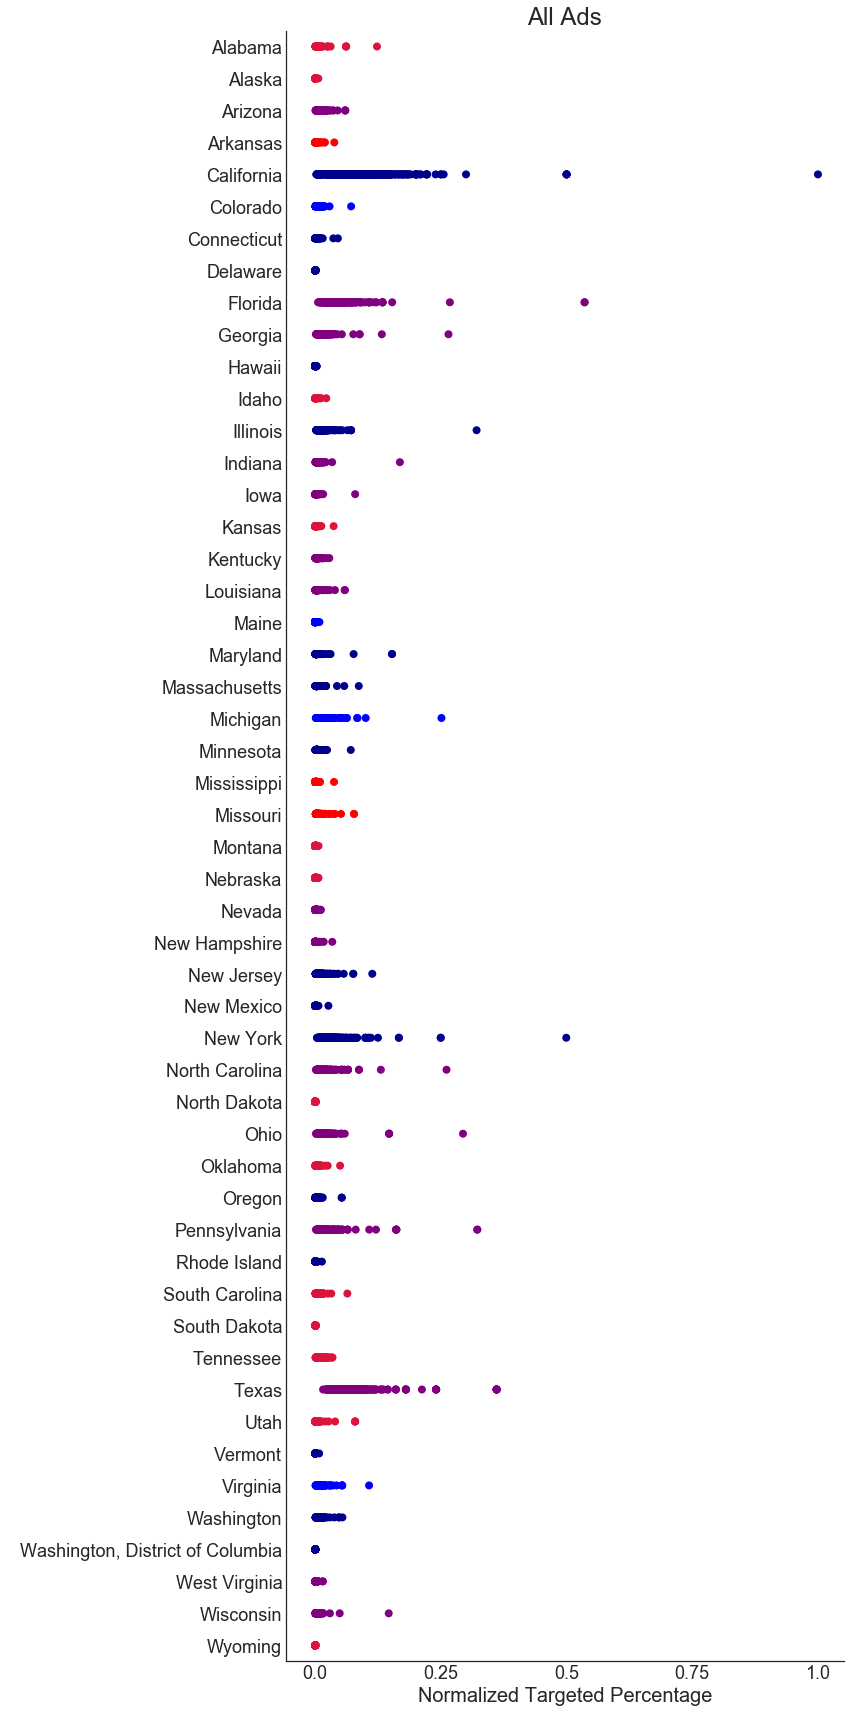

In [65]:
make_plot(df, title='All Ads')

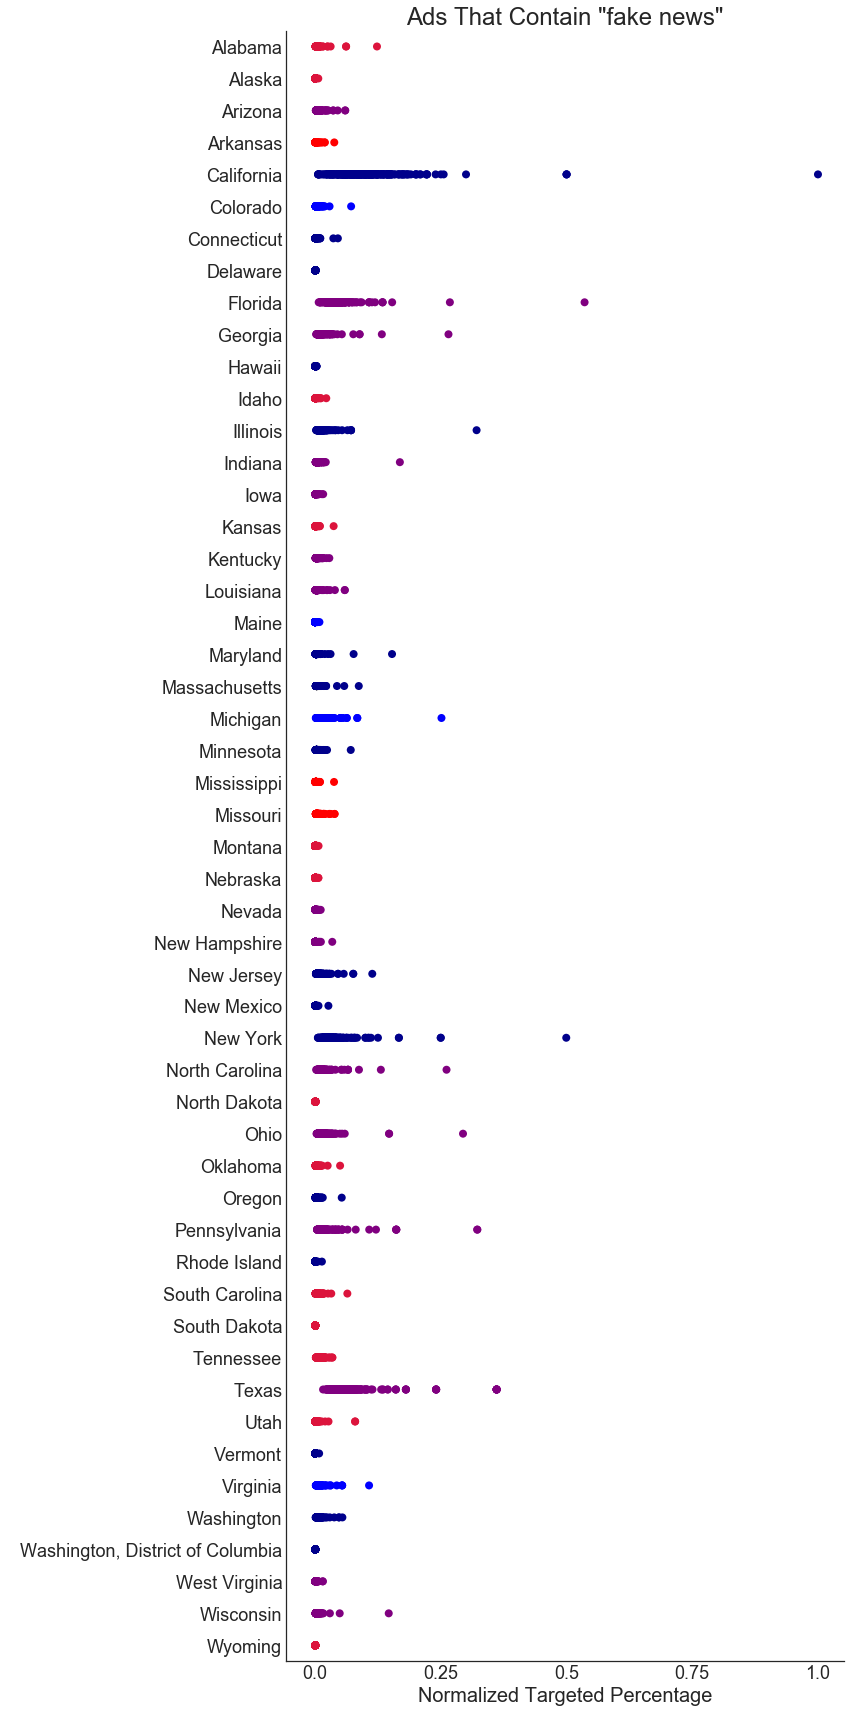

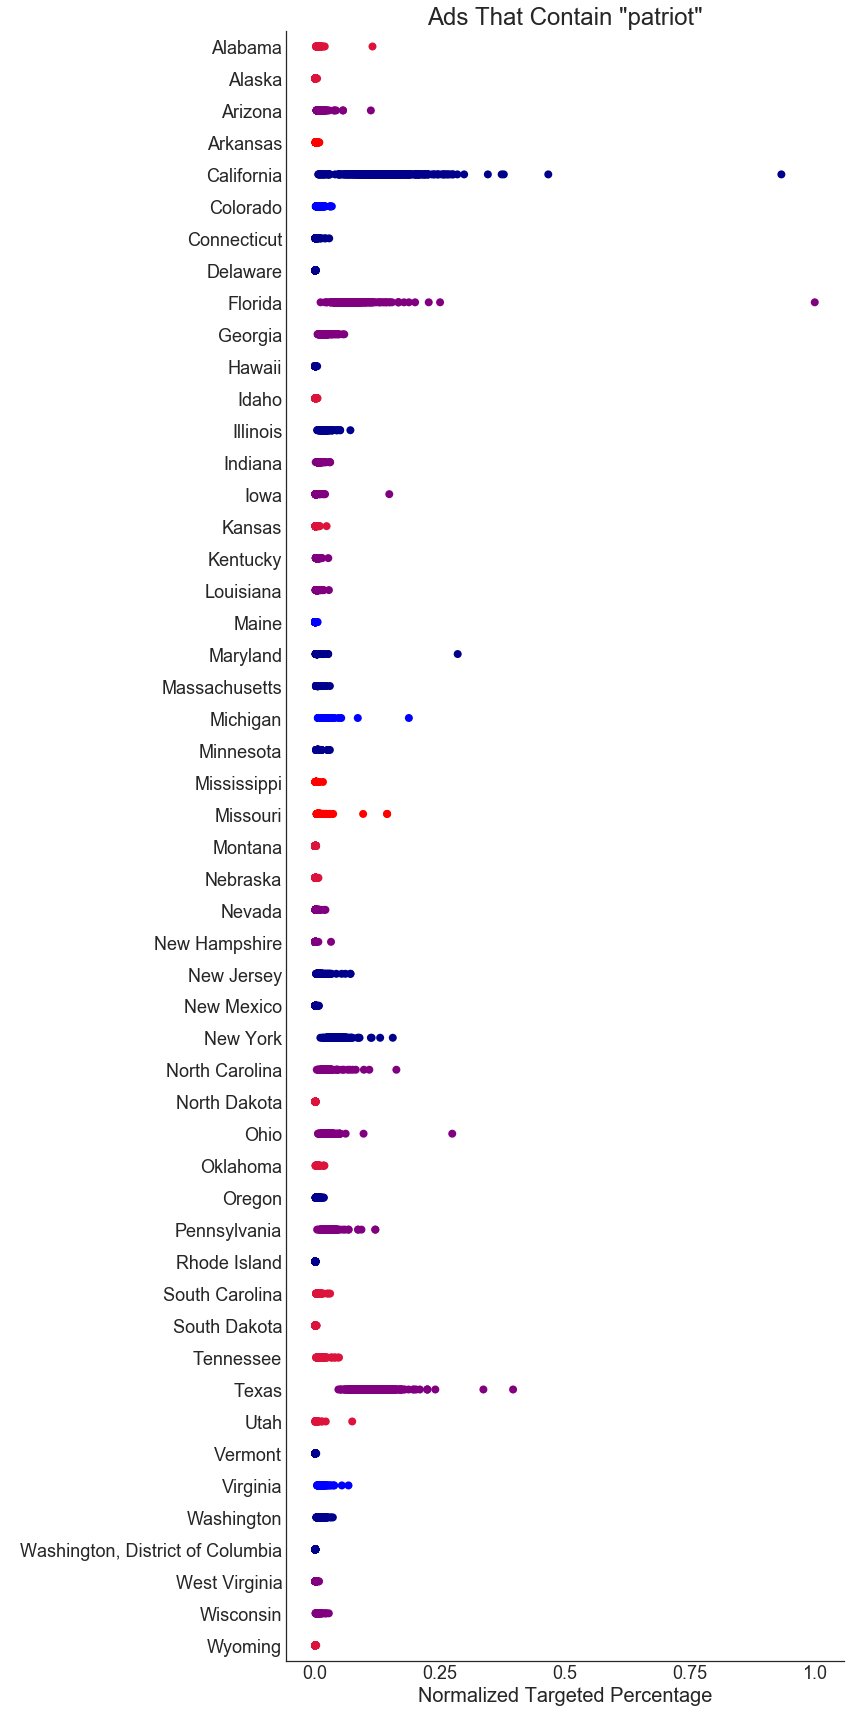

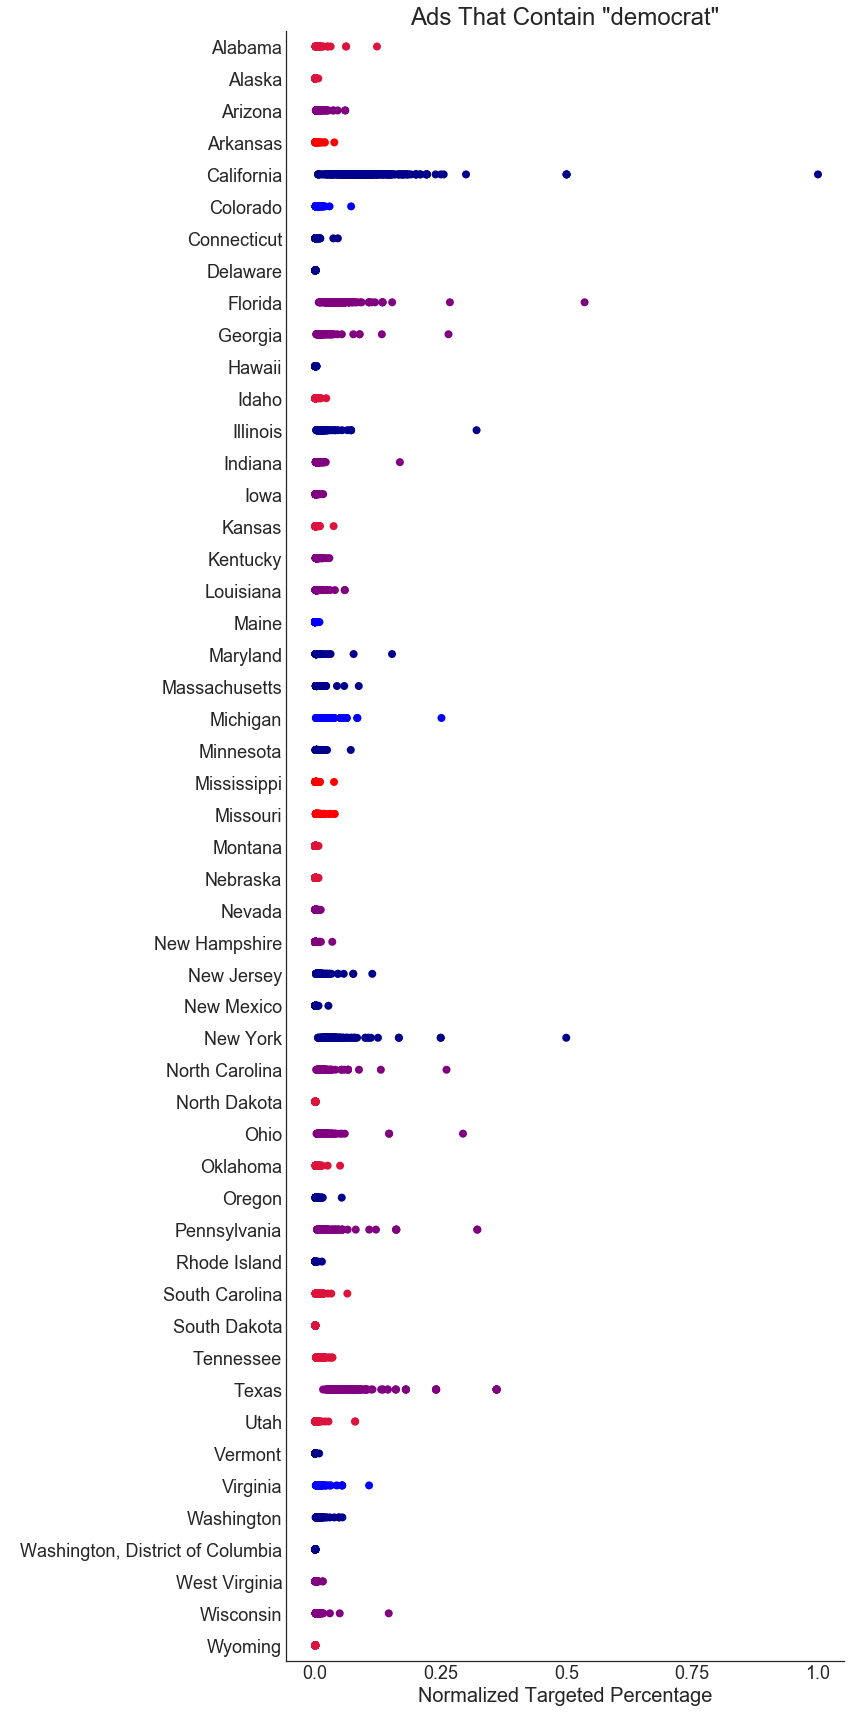

In [66]:
for search_term in search_terms:
    make_plot(df[df['contains_{}'.format(search_term)] == True], title='Ads That Contain "{}"'.format(search_term))